In [2]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
from sklearn.metrics import *
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split

In [11]:
df0 = pd.read_csv('../data/churn_train.csv')
df = df0.copy()

In [12]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


---
### Pipeline

---

In [14]:
def pipeline(df):
    # Sorts from earliest last_trip_date to the latest
    df = df.sort_values(by = ['last_trip_date'])
    # Fill NaNs of average ratings by the average of all the ratings
    df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace = True)
    df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace = True)
    df.dropna(axis = 0, inplace = True)
    # Convert string date to date time
    df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
    # Create a new binary column that indicates churn based on specific churn date established
    df['churn'] = df['last_trip_date'] < '2014-06-01'
    df['churn'] = df['churn'] * 1
    # Convert phone device and luxury car user to binary values
    df['phone'] = df['phone'] == 'iPhone'
    df['phone'] = df['phone'] * 1
    df['luxury_car_user'] = df['luxury_car_user'] * 1
    # Categorize the cities
    df = pd.get_dummies(df, columns = ['city'], drop_first = False)
    return df

In [15]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [16]:
df = pipeline(df)

In [17]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn,city_Astapor,city_King's Landing,city_Winterfell
38107,13.75,5.0,5.000000,1.00,2014-01-01,1,2014-01-01,0.0,2,0,100.0,1,0,0,1
35244,3.59,5.0,4.601697,1.00,2014-01-01,1,2014-01-01,0.0,1,1,100.0,1,0,0,1
1449,2.45,5.0,5.000000,1.25,2014-01-01,1,2014-01-01,100.0,1,0,100.0,1,1,0,0
9287,4.45,5.0,2.000000,1.00,2014-01-01,1,2014-01-01,0.0,1,0,100.0,1,0,0,1
7168,18.36,5.0,4.000000,1.00,2014-01-01,0,2014-01-01,0.0,1,0,100.0,1,0,0,1


---
### Train/Test Split

---

In [18]:
X = df.drop(columns = ['signup_date','last_trip_date','churn'])
y = df['churn']

In [21]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 11)

---
### Modeling
---

In [22]:
# Metrics function
def metrics(y_test, y_pred):
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    print("Confusion Matrix: ", confusion_matrix(y_test, y_pred, labels = [1,0]))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print(" F1 Ccore: ", f1_score(y_test, y_pred, average = 'weighted'))
    return

In [23]:
# Predicted targets
def model_pred(X_train, y_train, X_test, y_test, model, trees = 100):
    if model == LogisticRegression:
        model = model()
    else:
        model = model(n_estimators = trees)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

In [24]:
# Running Models
y_pred1, y_pred_probs1 = model_pred(X_train, y_train, X_test, y_test, LogisticRegression)
y_pred2, y_pred_probs2 = model_pred(X_train, y_train, X_test, y_test, RandomForestClassifier)
y_pred3, y_pred_probs3 = model_pred(X_train, y_train, X_test, y_test, GradientBoostingClassifier)

In [25]:
# Function for Plotting ROC-Curves
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, model1, model2, model3):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1)
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2)
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3)
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return 

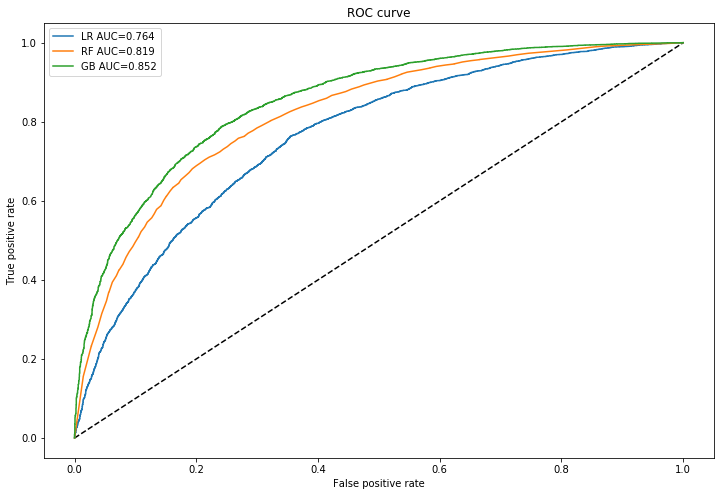

In [26]:
# ROC Curve
ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2,y_pred_probs3, 'LR', 'RF','GB')

---
### Profit Curves
---